# Build ML Model from a table
Ramin Anushiravani


In [26]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from matplotlib.pylab import plt
import numpy as np
from IPython.display import clear_output   
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging
import tensorflow
tensorflow.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings('ignore')
import pickle
from utils.config import config
from utils.model_utils import ModelUtil
from utils.data_utils import DataUtil
import librosa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EDA 

In [2]:
filename = 'data/input_data.csv'
df = pd.read_csv(filename)


## PCA

In [16]:
filename = 'data/Q1_Q2_data.csv'
project_data_pca = FeatObj.viz_projected_data(filename,projection='pca')

## T-SNE

In [17]:
project_data_tsne = FeatObj.viz_projected_data(filename,projection='tsne')

# Model - Prepping Data

In [28]:
x_train_norm,y_train,x_test_norm,y_test =  FeatObj.load_norm_data(filename)
ModelObj = ModelUtil(verbose=1)

### Logistic Regression

In [29]:
# since data is sparse, L1 loss might work better than L2 for raw data. 
m_name = "logistic regression"
params = config(m_name)
pd.DataFrame(params).head() # hyperparameters to try out for logistic regression

,Model,Feature,C,Penalty,num_feat,class_weight,solver
0,logistic regression,raw,0.9,l1,0,"{0: 0.6, 1: 0.4}",liblinear
1,logistic regression,eng,0.9,l1,0,"{0: 0.6, 1: 0.4}",liblinear
2,logistic regression,eng,0.9,l2,0,"{0: 0.6, 1: 0.4}",liblinear
3,logistic regression,raw,0.9,l1,0,"{0: 0.5, 1: 0.5}",liblinear
4,logistic regression,raw,0.9,l2,0,"{0: 0.5, 1: 0.5}",lbfgs


In [74]:
from sklearn.linear_model import LogisticRegression

for param in params:
    if param['Feature'] in feat_selected:
        X_train,X_test = FeatObj.input_data(X_train = x_train_norm, X_test = x_test_norm, feature_name=param['Feature'], num_feat = param['num_feat'])
        clf = LogisticRegression(penalty=param['Penalty'],solver=param['solver'],C=param['C'],class_weight=param['class_weight'])
        train_score,valid_score = ModelObj.cross_validation(clf,X_train,y_train)
        ModelObj.store_params(param,valid_score)
          
bh_1 = ModelObj.find_best_hyperparameters(m_name)
print(bh_1)


training score 0.8390 validation score 0.7920
training score 0.8430 validation score 0.7930
training score 0.8430 validation score 0.7900
training score 0.8160 validation score 0.8060
training score 0.8110 validation score 0.8020
training score 0.8120 validation score 0.8040
training score 0.8170 validation score 0.8010
training score 0.8120 validation score 0.8060
training score 0.8100 validation score 0.8050
Model logistic regression 
 {'Model': 'logistic regression', 'Feature': 'pca', 'C': 0.9, 'num_feat': 64, 'Penalty': 'l2', 'class_weight': {0: 0.5, 1: 0.5}, 'solver': 'lbfgs'} 
 validation score: 0.8060
{'Model': 'logistic regression', 'Feature': 'pca', 'C': 0.9, 'num_feat': 64, 'Penalty': 'l2', 'class_weight': {0: 0.5, 1: 0.5}, 'solver': 'lbfgs'}


### SVM

In [75]:
m_name = 'SVM'
params = config(m_name)
pd.DataFrame(params).head()

,Model,Feature,num_feat,C
0,SVM,pca,32,0.8
1,SVM,pca,64,0.8
2,SVM,pca,64,0.6
3,SVM,pca,128,0.6
4,SVM,pca,128,0.6


In [76]:
from sklearn import svm
# since SVM takes much longer to train, trying fewer hyperparameters

for param in params:
    if param['Feature'] in feat_selected:
        X_train,X_test = FeatObj.input_data(X_train = x_train_norm, X_test = x_test_norm, feature_name=param['Feature'], num_feat = param['num_feat'])
        clf = svm.SVC(kernel='rbf',decision_function_shape='ovo',probability=True,C=param['C'])
        train_score,valid_score = ModelObj.cross_validation(clf,X_train,y_train)
        ModelObj.store_params(param,valid_score)
 
bh_2 = ModelObj.find_best_hyperparameters(m_name)
print(bh_2)


training score 0.8680 validation score 0.8090
training score 0.8860 validation score 0.8060
training score 0.8740 validation score 0.8070
training score 0.8840 validation score 0.8030
training score 0.8830 validation score 0.8030
training score 0.8930 validation score 0.8000
training score 0.8930 validation score 0.8000
training score 0.9290 validation score 0.8000
Model SVM 
 {'Model': 'SVM', 'Feature': 'pca', 'num_feat': 32, 'C': 0.8} 
 validation score: 0.8090
{'Model': 'SVM', 'Feature': 'pca', 'num_feat': 32, 'C': 0.8}


### RF

random forest might also be a good option, though they're difficult to tune and more prone to overfitting


In [77]:
m_name = 'RF'
params = config(m_name)
pd.DataFrame(params).head()

,Model,Feature,num_feat,depth
0,RF,pca,32,9
1,RF,pca,64,9
2,RF,pca,64,7
3,RF,pca,128,7
4,RF,pca,128,7


In [78]:
from sklearn.ensemble import RandomForestClassifier

for param in params:
    if param['Feature'] in feat_selected:
        X_train,X_test = FeatObj.input_data(X_train = x_train_norm, X_test = x_test_norm, feature_name=param['Feature'], num_feat = param['num_feat'])
        clf = RandomForestClassifier(max_depth=param['depth'], random_state=0)
        train_score,valid_score = ModelObj.cross_validation(clf,X_train,y_train)
        ModelObj.store_params(param,valid_score)

bh_3 = ModelObj.find_best_hyperparameters(m_name)
print(bh_3)


training score 0.8530 validation score 0.8020
training score 0.8500 validation score 0.7960
training score 0.8170 validation score 0.7900
training score 0.8110 validation score 0.7780
training score 0.8120 validation score 0.7770
training score 0.8060 validation score 0.7550
training score 0.8070 validation score 0.7490
training score 0.8200 validation score 0.7470
training score 0.9920 validation score 0.7740
Model RF 
 {'Model': 'RF', 'Feature': 'pca', 'num_feat': 32, 'depth': 9} 
 validation score: 0.8020
{'Model': 'RF', 'Feature': 'pca', 'num_feat': 32, 'depth': 9}


### Perceptron

In [82]:
m_name = 'Perceptron'
params = config(m_name)
pd.DataFrame(params).head()

,Model,Feature,num_feat,hidden_layer,alpha,lr,activation
0,Perceptron,pca,128,1024,0.2,0.05,relu
1,Perceptron,pca,64,512,0.2,0.05,relu
2,Perceptron,pca,128,512,0.2,0.05,relu
3,Perceptron,pca,128,"(512, 128)",0.2,0.05,relu
4,Perceptron,pca,32,"(512, 128)",0.2,0.05,relu


In [83]:
from sklearn.neural_network import MLPClassifier

for param in params:
    if param['Feature'] in feat_selected:
        X_train,X_test = FeatObj.input_data(X_train = x_train_norm, X_test = x_test_norm, feature_name=param['Feature'], num_feat = param['num_feat'])

        clf = MLPClassifier(random_state=1, max_iter=20,
                            hidden_layer_sizes=param['hidden_layer'],alpha=param['alpha'],
                            activation=param['activation'],learning_rate_init=param['lr'])
        train_score,valid_score = ModelObj.cross_validation(clf,X_train,y_train)
        ModelObj.store_params(param,valid_score)

bh_4 = ModelObj.find_best_hyperparameters(m_name)
print(bh_4)


training score 0.8150 validation score 0.7980
training score 0.8170 validation score 0.8040
training score 0.8150 validation score 0.7990
training score 0.8150 validation score 0.7960
training score 0.8210 validation score 0.8090
training score 0.8180 validation score 0.8060
training score 0.6390 validation score 0.6340
training score 0.8170 validation score 0.8060
training score 0.8140 validation score 0.7990
training score 0.8180 validation score 0.8040
training score 0.8380 validation score 0.7900
training score 0.8330 validation score 0.7820
training score 0.8360 validation score 0.7870
training score 0.6390 validation score 0.6340
training score 0.8350 validation score 0.7920
training score 0.7990 validation score 0.7720
Model Perceptron 
 {'Model': 'Perceptron', 'Feature': 'pca', 'num_feat': 32, 'hidden_layer': (512, 128), 'alpha': 0.2, 'lr': 0.05, 'activation': 'relu'} 
 validation score: 0.8090
{'Model': 'Perceptron', 'Feature': 'pca', 'num_feat': 32, 'hidden_layer': (512, 128)

### FFNN

In [84]:
m_name = 'FFNN'
params = config(m_name)
pd.DataFrame(params).head()

,Model,Feature,num_feat,model_num,lr,batch_size
0,FFNN,raw,0,1,0.0001,32
1,FFNN,raw,0,2,0.0001,32
2,FFNN,raw,0,3,0.0001,32
3,FFNN,pca,64,1,0.0010,32
4,FFNN,pca,128,1,0.0010,32


In [85]:
from utils.ffnn import FFNN
ffnnObj = FFNN(verbose=0)

for param in params:
    if param['Feature'] in feat_selected:
        X_train,X_test = FeatObj.input_data(X_train = x_train_norm, X_test = x_test_norm, feature_name=param['Feature'], num_feat = param['num_feat'])
        model_ = ffnnObj.train_FFNN(X_train,y_train,model_num = param['model_num'],lr=param['lr'],epochs=25,num_folds=5)
        valid_score = model_.history.history['val_accuracy'][0]
        ModelObj.store_params(param,valid_score)

bh_5 = ModelObj.find_best_hyperparameters(m_name)
print(bh_5)


Model FFNN 
 {'Model': 'FFNN', 'Feature': 'pca', 'num_feat': 64, 'model_num': 5, 'lr': 0.001, 'batch_size': 64} 
 validation score: 0.8116
{'Model': 'FFNN', 'Feature': 'pca', 'num_feat': 64, 'model_num': 5, 'lr': 0.001, 'batch_size': 64}


Create a dataframe of all hyperparameters that has been tried out in the previous steps


In [113]:
hyperparameters = []
for k in ModelObj.hyperparameter_search.keys():
    hps = ModelObj.hyperparameter_search[k]
    for hp in hps:
        hp['valid'] = k
        hyperparameters.append(hp)
        
df = pd.DataFrame(hyperparameters).fillna('-')
df.to_csv('models/hyperparameter_search.csv')
df.sample(frac=1)

,Model,Feature,C,Penalty,num_feat,class_weight,solver,valid,hidden_layer,alpha,lr,activation,depth,model_num,batch_size
50,FFNN,pca,-,-,256,-,-,0.779688,-,-,0.001,-,-,2.0,32.0
5,RF,pca,-,-,64,-,-,0.790000,-,-,-,-,7.0,-,-
16,Perceptron,pca,-,-,64,-,-,0.804000,512,0.2,0.05,relu,-,-,-
4,logistic regression,raw,0.9,l2,0,"{0: 0.5, 1: 0.5}",lbfgs,0.790000,-,-,-,-,-,-,-
54,FFNN,pca,-,-,256,-,-,0.676250,-,-,0.0005,-,-,3.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,FFNN,pca,-,-,32,-,-,0.801250,-,-,0.001,-,-,3.0,32.0
19,logistic regression,pca,0.9,l2,32,"{0: 0.5, 1: 0.5}",lbfgs,0.805000,-,-,-,-,-,-,-
13,logistic regression,pca,0.9,l1,128,"{0: 0.6, 1: 0.4}",liblinear,0.802000,-,-,-,-,-,-,-
7,Perceptron,raw,-,-,0,-,-,0.790000,1024,0.2,0.05,relu,-,-,-


collecting all the parameters that were identified as best for each of the models 


In [114]:
best_of_each_models_hyperparams = [bh_1,bh_2,bh_3,bh_4,bh_5]
candidates_hyperparams = []
for x in best_of_each_models_hyperparams:
    candidates_hyperparams.append(x) # picking on config per model 
    

Training and saving best model from each option, saving them, and evaluating them on test set
== Training model on best hyper and testing on test set


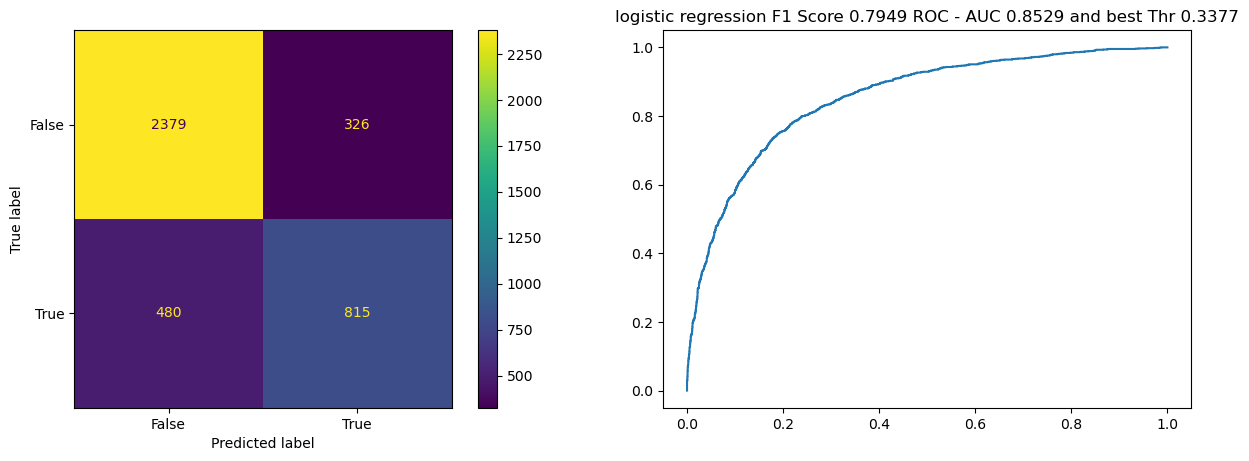

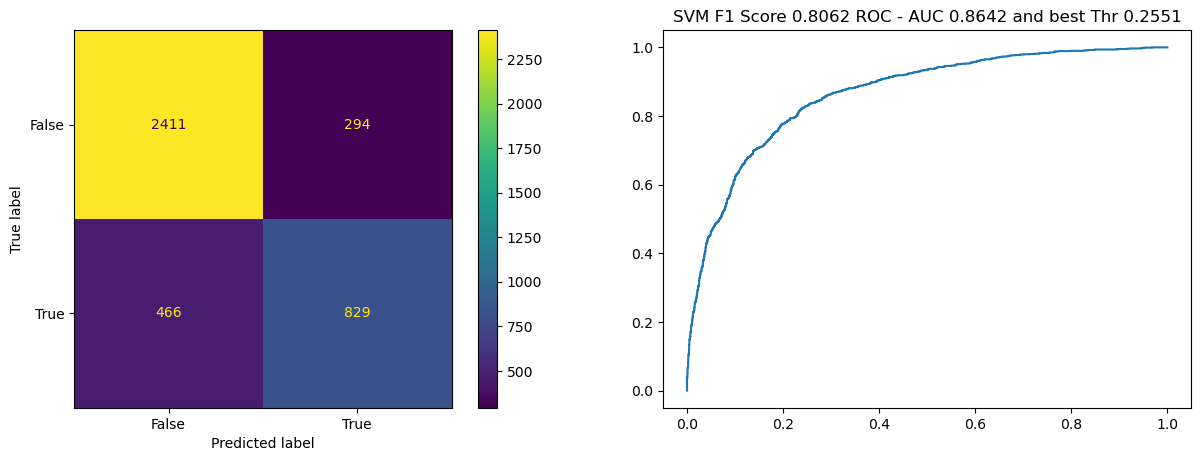

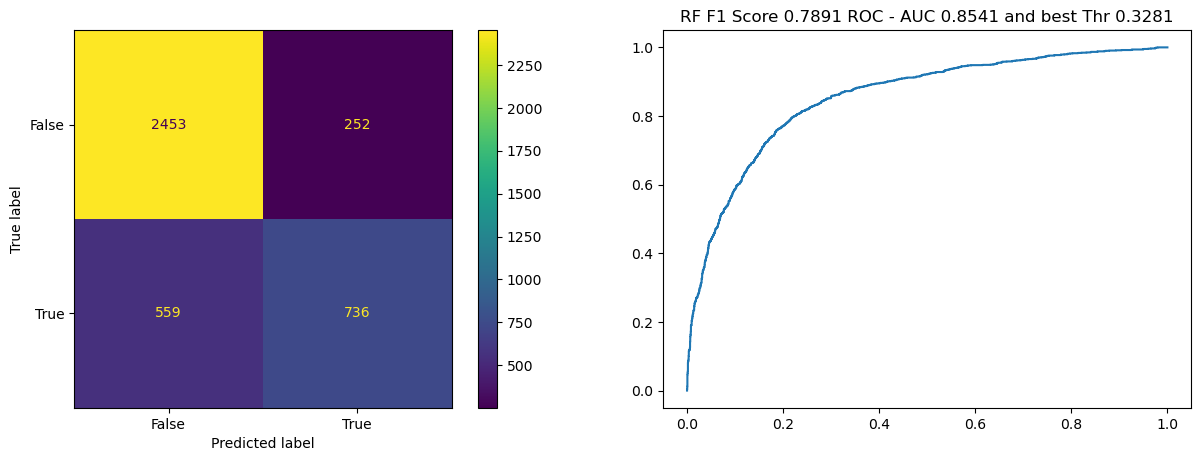

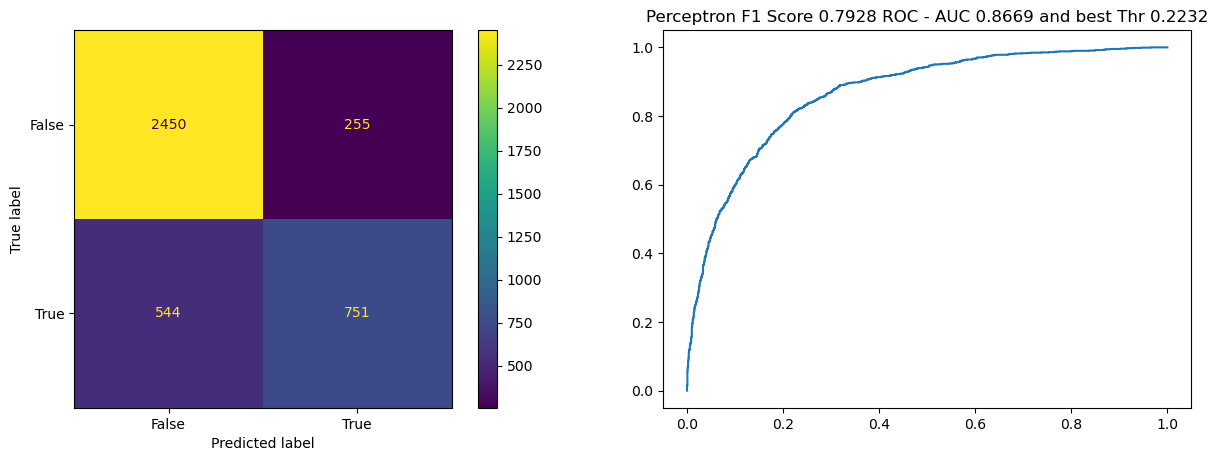

125/125 [==============================] - 0s 886us/step


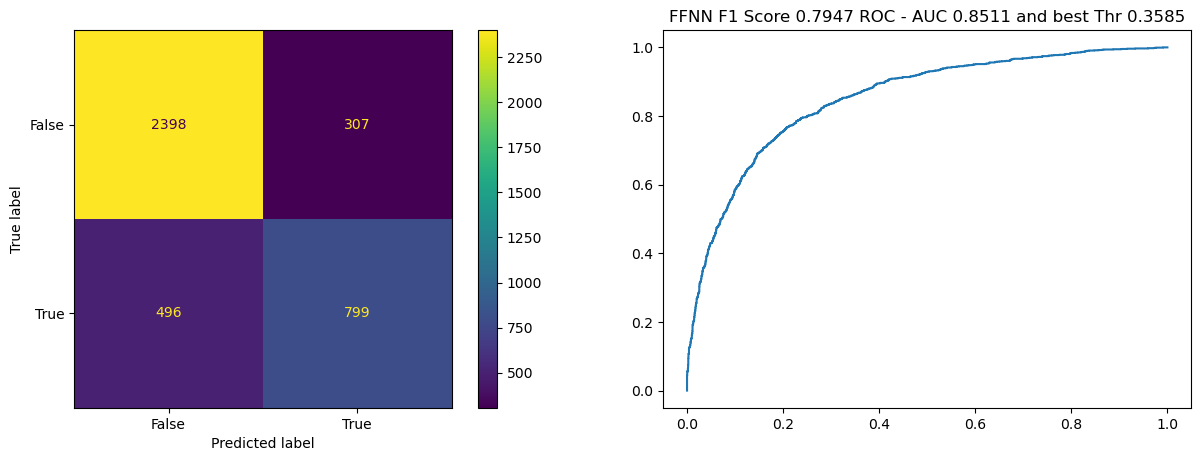

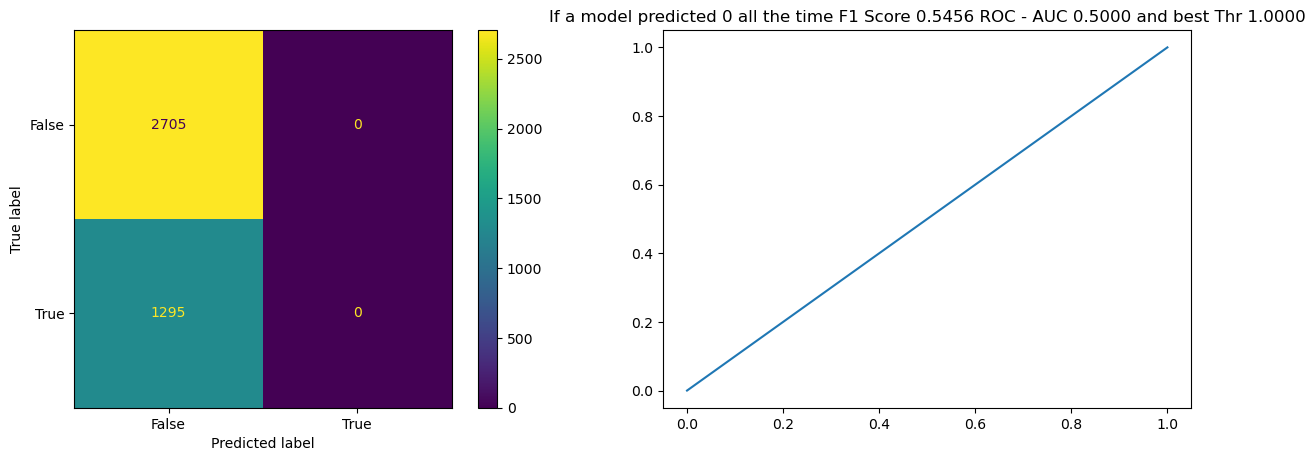

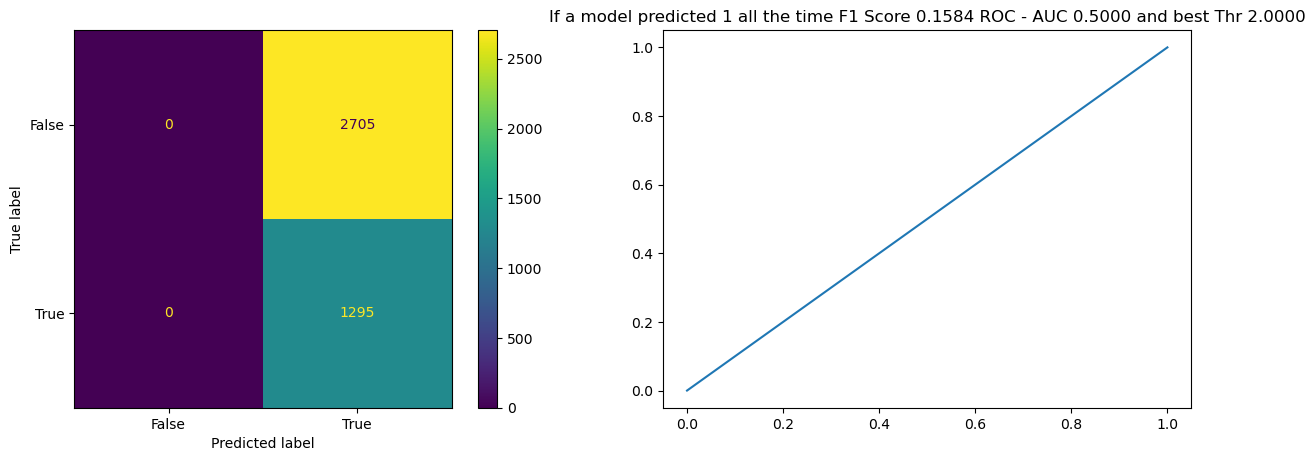

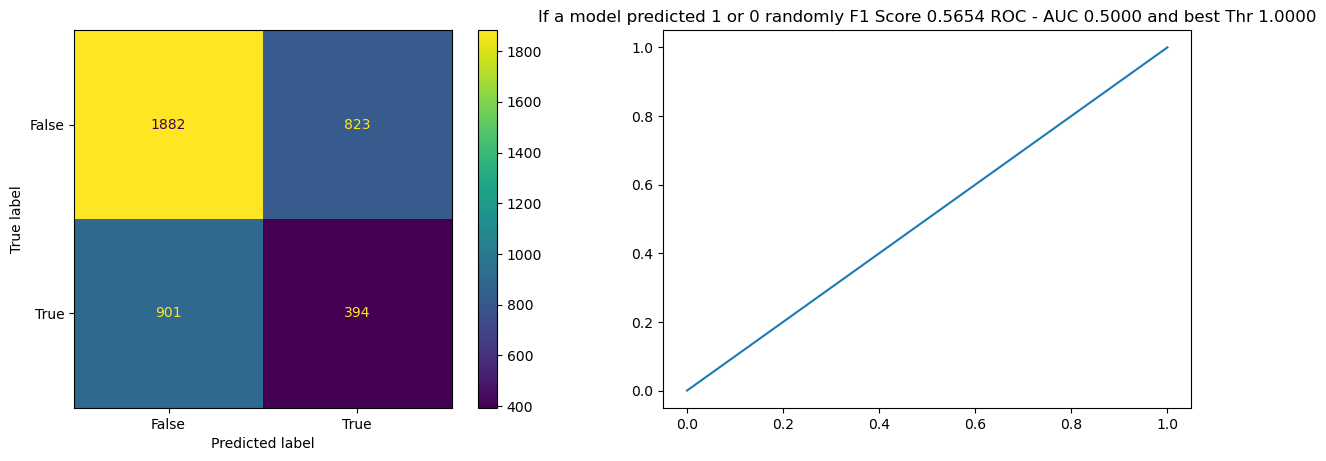

In [115]:
for param in candidates_hyperparams:  
    if param['Model'] == 'logistic regression':
        X_train,X_test = FeatObj.input_data(X_train = x_train_norm, X_test = x_test_norm, feature_name=param['Feature'], num_feat = param['num_feat'])
        clf = LogisticRegression(penalty=param['Penalty'],solver=param['solver'],C=param['C'],class_weight=param['class_weight'])
        clf.fit(X_train,y_train) 
        
    elif param['Model'] == 'RF':
        X_train,X_test = FeatObj.input_data(X_train = x_train_norm, X_test = x_test_norm, feature_name=param['Feature'], num_feat = param['num_feat'])
        clf = RandomForestClassifier(max_depth=param['depth'], random_state=0)
        clf.fit(X_train,y_train) 
        
    elif param['Model'] == 'SVM':
        X_train,X_test = FeatObj.input_data(X_train = x_train_norm, X_test = x_test_norm, feature_name=param['Feature'], num_feat = param['num_feat'])
        clf = svm.SVC(kernel='rbf',decision_function_shape='ovo',probability=True,C=param['C'])
        clf.fit(X_train,y_train) 
        
    elif param['Model'] == 'Perceptron':
        X_train,X_test = FeatObj.input_data(X_train = x_train_norm, X_test = x_test_norm, feature_name=param['Feature'], num_feat = param['num_feat'])
        clf = MLPClassifier(random_state=1, max_iter=10,
                    hidden_layer_sizes=param['hidden_layer'],alpha=param['alpha'],
                    activation=param['activation'],learning_rate_init=param['lr'])
        clf.fit(X_train,y_train) 
        
    elif param['Model'] == 'FFNN':
        X_train,X_test = FeatObj.input_data(X_train = x_train_norm, X_test = x_test_norm, feature_name=param['Feature'], num_feat = param['num_feat'])
        model_ = ffnnObj.train_FFNN(X_train,y_train,model_num = param['model_num'],lr=param['lr'],epochs=25,num_folds=1)
        prediction_prob = model_.predict(X_test).ravel()

    ## SAVING Models ## 
    
    if param['Model'] == 'FFNN':
        filename = param['Model'] + '.h5'
        model_.save('models/'+filename)        
    else:
        filename = param['Model'] + '.sav'
        pickle.dump(clf, open('models/'+filename, 'wb'))
        # CLF predictions 
        prediction_prob = clf.predict_proba(X_test)
        
    # Plot ROC 
    ModelObj.plot_cm_roc(prediction_prob,y_test,name = param['Model'])
    

    
ModelObj.plot_cm_roc(y_test*0 ,y_test,name = "If a model predicted 0 all the time")
ModelObj.plot_cm_roc(y_test>=0,y_test,name = "If a model predicted 1 all the time")

random_test = [1 if np.random.randn()>0.5 else 0 for i in range(len(y_test)) ]

ModelObj.plot_cm_roc(random_test,y_test,name = "If a model predicted 1 or 0 randomly")

    

# Q2 Training and Evaluating on Block 0 only

In [1]:
df = pd.read_csv('data/input_data.csv')
df = df.fillna(method="pad")
x_cols = [col for col in df.columns if 'x' in col]

# Using only block 0 for training and evaluation 
X_0 = df[x_cols].to_numpy()
y_0 = df_0['y'].to_numpy()

normlizer = FeatObj.normalizer(X_0)
X_0_norm = normlizer.transform(X_0)

    
# Leaving 10% for Testing 
percentage_split = 0.9
X_train_0 = X_0_norm[0:int(percentage_split*len(X_0_norm)),:]
y_train_0 = y_0[0:int(percentage_split*len(X_0_norm))]

X_test_0 = X_0_norm[int(percentage_split*len(X_0_norm)):,:]
y_test_0 = y_0[int(percentage_split*len(X_0_norm)):]
plt.plot(y_test_0)
plt.title("test data labels")
plt.show() # verifying that it's got both classes

ModelObj.plot_cm_roc(y_test_0,y_test_0,name = 'Ground Truth')


Let's go with : 

- FFNN
- SVM

Training on 90% of block 0 with 5 fold X-validation, then picking the best parameters. Then pick that model and test it on the 10% it hasn't seem and hopefully matches what will be collected during production. 

## Instantiating model utility for testing

In [91]:
ModelObj_Test = ModelUtil(verbose=1)
feat_selected = ['raw','pca']

## FFNN

Training on 90% of block 0 with 5 fold X-validation and testing on the remaining 10%

In [93]:
from utils.ffnn import FFNN
ffnnObj = FFNN(verbose=0)

m_name = 'FFNN'
params = config(m_name)

for param in params:
    if param['Feature'] in feat_selected:
        X_train_00,_     = FeatObj.input_data(X_train = X_train_0,X_test =[], feature_name=param['Feature'], num_feat = param['num_feat'])
        model_   = ffnnObj.train_FFNN(X_train_00,y_train_0,model_num = param['model_num'],lr=param['lr'],epochs=11,num_folds=5)
        valid_score = model_.history.history['val_accuracy'][0]
        ModelObj_Test.store_params(param,valid_score)
  

Training FFNN with bh_6 config


Model FFNN 
 {'Model': 'FFNN', 'Feature': 'pca', 'num_feat': 128, 'model_num': 5, 'lr': 0.001, 'batch_size': 64} 
 validation score: 0.8361
13/13 [==============================] - 0s 886us/step


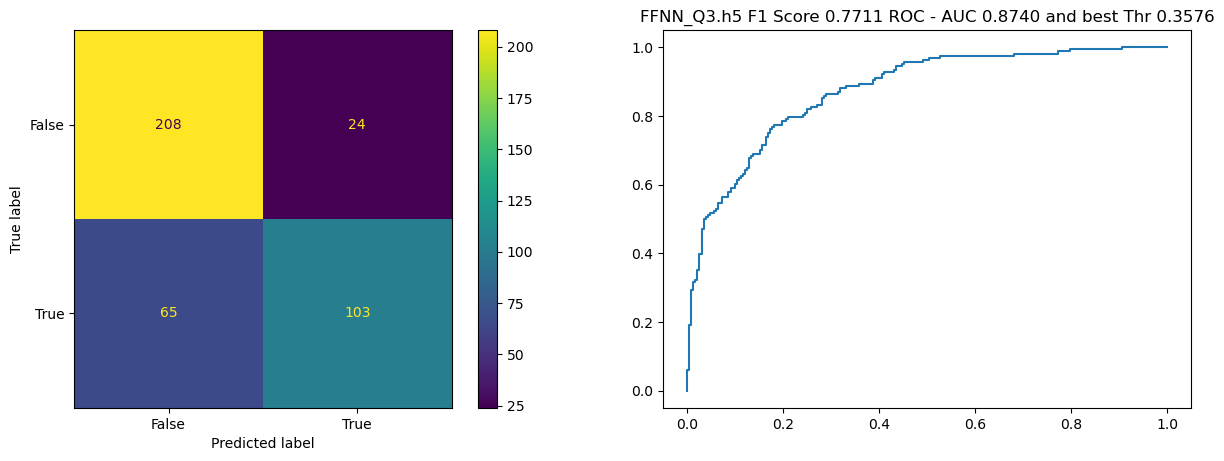

In [94]:

bh_6 = ModelObj_Test.find_best_hyperparameters(m_name) # finding best parameters

X_train_final,X_test_final = FeatObj.input_data(X_train = X_train_0, X_test = X_test_0, feature_name=bh_6['Feature'], num_feat = bh_6['num_feat'])
model_selected = ffnnObj.train_FFNN(X_train_final,y_train_0,model_num = bh_6['model_num'],lr=bh_6['lr'],epochs=20,num_folds=1)

filename = bh_6['Model'] + '_Q3.h5'

# Testing the model on test data
prediction_prob = model_selected.predict(X_test_final).ravel()  
ModelObj_Test.plot_cm_roc(prediction_prob,y_test_0,name = filename)


## SVM

Training on 90% of block 0 with 5 fold X-validation and testing on the remaining 10%

In [95]:

m_name = 'SVM'
params = config(m_name)
for param in params:
    if param['Feature'] in feat_selected:

        X_train_00,_ = FeatObj.input_data(X_train = X_train_0, X_test = [], feature_name=param['Feature'], num_feat = param['num_feat'])
        clf = svm.SVC(kernel='rbf',decision_function_shape='ovo',probability=True,C=param['C'])
        clf.fit(X_train_00,y_train_0)
        train_score,valid_score = ModelObj_Test.cross_validation(clf,X_train_00,y_train_0)
        ModelObj_Test.store_params(param,valid_score)



training score 0.8860 validation score 0.8020
training score 0.9050 validation score 0.7880
training score 0.8840 validation score 0.7880
training score 0.8900 validation score 0.7810
training score 0.8900 validation score 0.7830
training score 0.9010 validation score 0.7620
training score 0.9010 validation score 0.7640
training score 0.9620 validation score 0.7820


Training SVM on bh_8 config


Model SVM 
 {'Model': 'SVM', 'Feature': 'pca', 'num_feat': 32, 'C': 0.8} 
 validation score: 0.8020


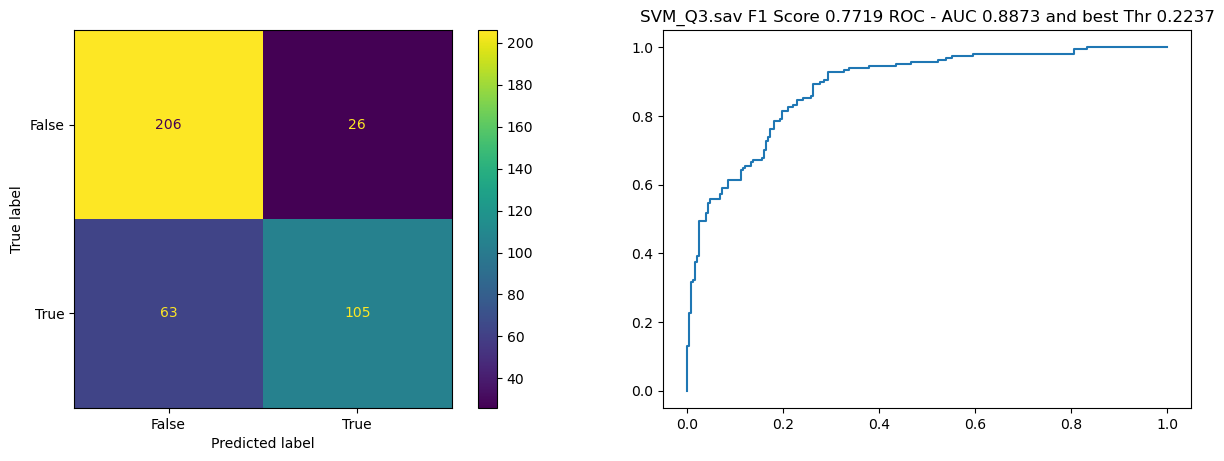

In [97]:

bh_8 = ModelObj_Test.find_best_hyperparameters(m_name) # finding best parameters

X_train_final,X_test_final = FeatObj.input_data(X_train = X_train_0, X_test = X_test_0, feature_name=bh_8['Feature'], num_feat = bh_8['num_feat'])
clf = svm.SVC(kernel='rbf',decision_function_shape='ovo',probability=True,C=param['C'])
clf.fit(X_train_final,y_train_0) 

# Saving the model
filename = bh_8['Model'] + '_Q3.sav'

# Testing the model on test data
prediction_prob = clf.predict_proba(X_test_final)
ModelObj_Test.plot_cm_roc(prediction_prob,y_test_0,name = filename)

# Saving model
X_train_final,_ = FeatObj.input_data(X_train = X_0_norm, X_test = [], feature_name=bh_8['Feature'], num_feat = bh_8['num_feat'])
clf.fit(X_train_final,y_0)
pickle.dump(clf, open('models/'+filename, 'wb'))


# Testing

In [98]:
from tensorflow import keras
from utils.data_utils import DataUtil

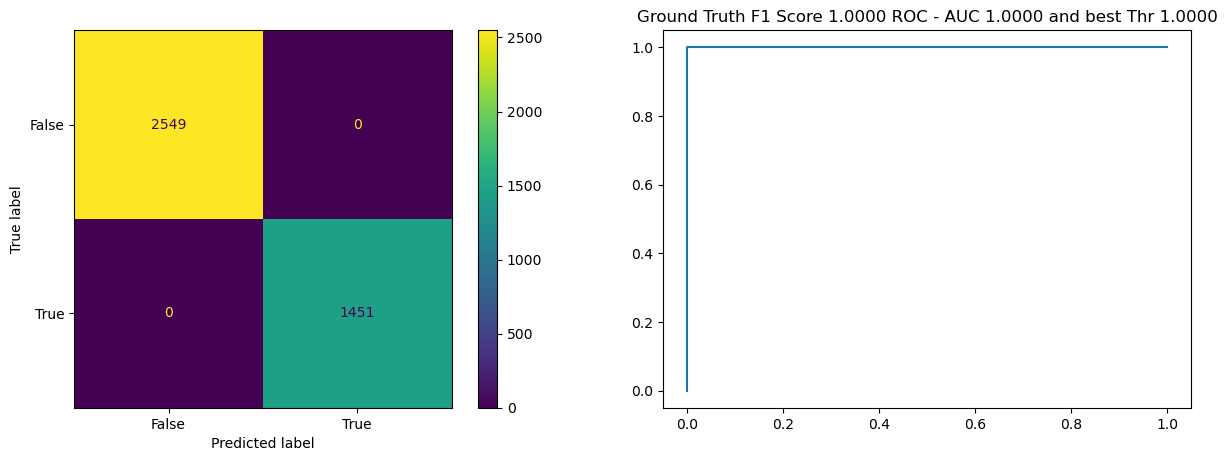

In [133]:
df = pd.read_csv('data/intput_data.csv')
df = df.fillna(method="pad")
x_cols = [col for col in df.columns if 'x' in col]

df_0 = df[df['block'] == 0]
X_raw = df_0[x_cols].to_numpy()
y_raw = df_0['y'].to_numpy()

normlizer = FeatObj.normalizer(X_raw)
X_raw_norm = normlizer.transform(X_raw)

ModelObj.plot_cm_roc(y_raw,y_raw,name = 'Ground Truth')


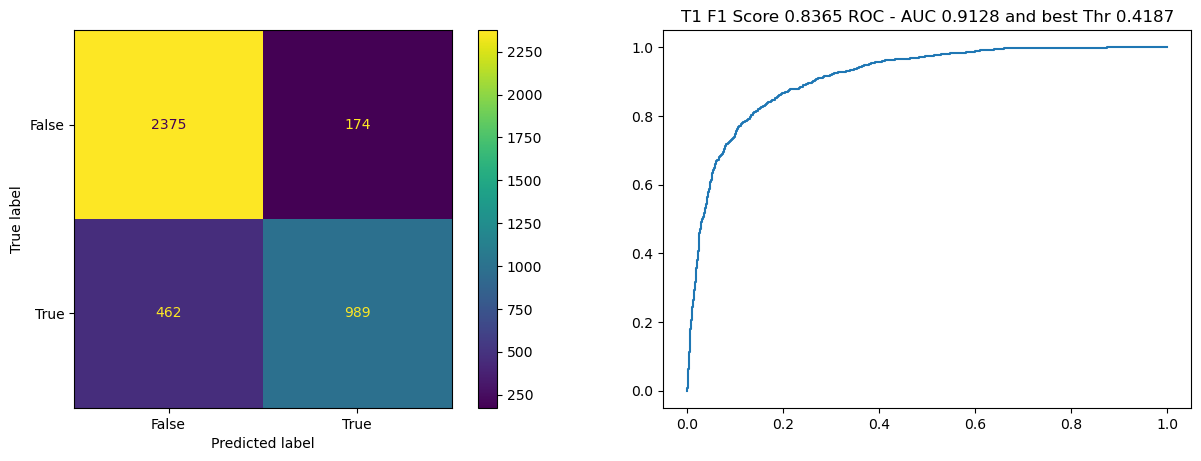

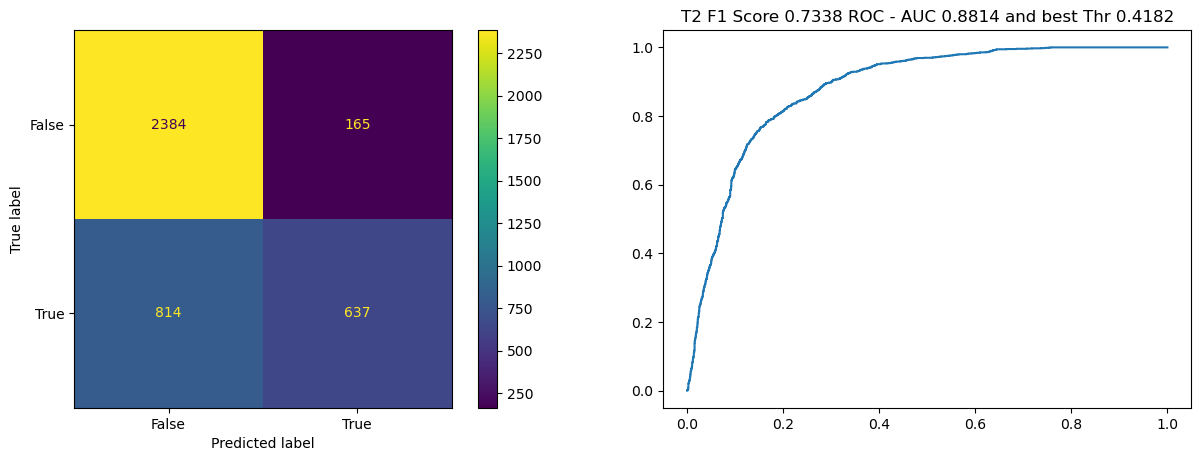

In [100]:
team_results = pd.read_csv('data/test_data.csv')

name_1 = 'T1'
predictions_1 = list(team_results[name_1])
ModelObj.plot_cm_roc(predictions_1,y_0,name = name_1)

name_2 = 'T2'
predictions_2 = list(team_results[name_2])
ModelObj.plot_cm_roc(predictions_2,y_0,name = name_2)

In [101]:
# Setting up the data to match what the teammate have probably done - a 5-fold x-valid

d = np.arange(len(X_raw_norm))

cs = [np.arange(0,int(0.2*len(X_raw_norm))),np.arange(int(0.2*len(X_raw_norm)),int(0.4*len(X_raw_norm))),
      np.arange(int(0.4*len(X_raw_norm)),int(0.6*len(X_raw_norm))),np.arange(int(0.6*len(X_raw_norm)),int(0.8*len(X_raw_norm))),
      np.arange(int(0.8*len(X_raw_norm)),len(X_raw_norm))]


25/25 [==============================] - 0s 933us/step


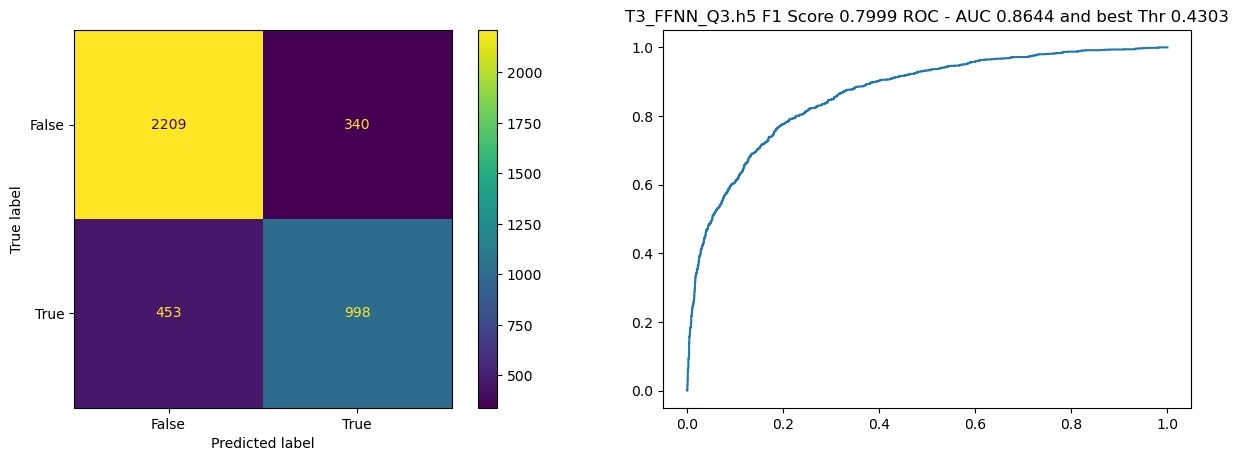

In [140]:
# FFNN
filename = bh_6['Model'] + '_Q3.h5'
name_31 = 'T3_' + filename

prediction_prob_ffnn = []

for i in range(len(cs)):
    # train model on 75% and predict on 25% using the params found from last step 
    sub_train = [x for x in d if x not in cs[i]]
    X_train,X_test = FeatObj.input_data(X_train = X_raw_norm[sub_train], X_test = X_raw_norm[cs[i]], feature_name = bh_6['Feature'], num_feat = bh_6['num_feat'])
    model_selected  = ffnnObj.train_FFNN(X_train,y_raw[sub_train],model_num =bh_6['model_num'], lr = bh_6['lr']/4,epochs=10,num_folds=1)
    prediction_prob_ffnn.append(model_selected.predict(X_test).ravel()) 

prediction_prob_ffnn = np.concatenate((prediction_prob_ffnn))
ModelObj.plot_cm_roc(prediction_prob_ffnn,y_raw,name = name_31)




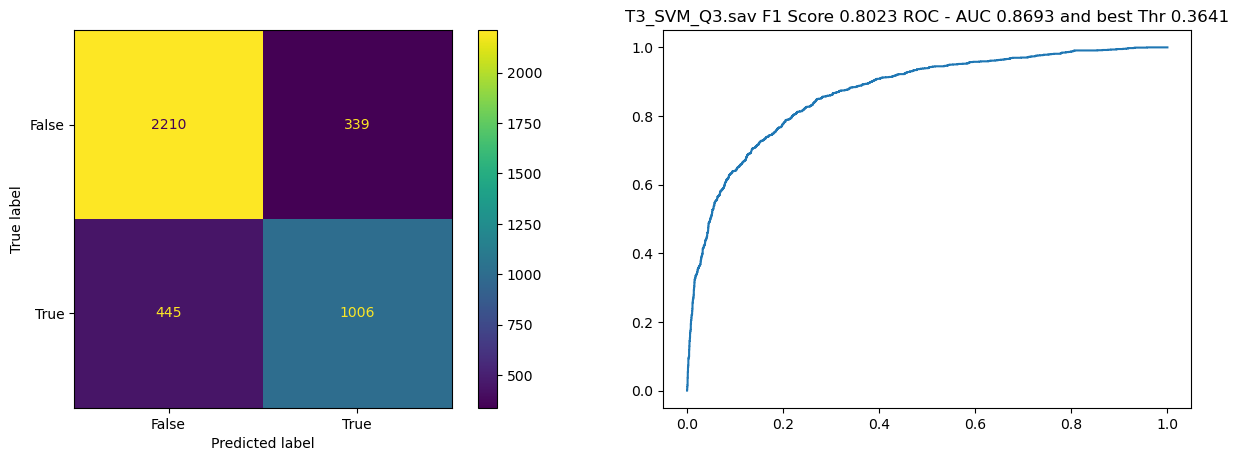

In [103]:
# SVM
filename = bh_8['Model'] + '_Q3.sav'
name_33 = 'T3_' + filename

prediction_prob_svm = []
for i in range(len(cs)):
    # Now, train model on 75% and predict on 25% using the params found from last step 
    sub_train = [x for x in d if x not in cs[i]]
    X_train,X_test = FeatObj.input_data(X_train = X_raw_norm[sub_train], X_test = X_raw_norm[cs[i]],
                                        feature_name=bh_8['Feature'], num_feat = bh_8['num_feat'])
    clf = svm.SVC(kernel='rbf',decision_function_shape='ovo',probability=True,C=bh_8['C'])
    clf.fit(X_train,y_raw[sub_train])
    prediction_prob_svm.append(clf.predict_proba(X_test))

prediction_prob_svm = np.concatenate((prediction_prob_svm))
ModelObj.plot_cm_roc(prediction_prob_svm,y_raw,name = name_33)


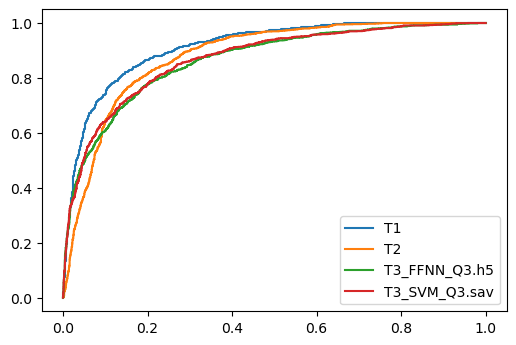

In [141]:
# Plotting the ROC curve from the teammates and two two models I tried out through x-valid block 0 
plt.figure(dpi=100)
x,y,_,_ = ModelObj.get_roc(predictions_1  , y_0)
plt.plot(x,y)
x,y,_,_ = ModelObj.get_roc(predictions_2  , y_0)
plt.plot(x,y)
x,y,_,_ = ModelObj.get_roc(prediction_prob_ffnn, y_0)
plt.plot(x,y)
x,y,_,_ = ModelObj.get_roc(prediction_prob_svm[:,1], y_0)
plt.plot(x,y)
plt.legend([name_1,name_2,name_31,name_33])